In [7]:
import abc # class inheritance
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Example Synthetic Data:

In [8]:
# Example Data
np.random.seed(33)
target = np.random.rand(500)
data = pd.DataFrame.from_dict({'target': target, 'x1': target * 2, 'x2': target ** 2, 'x3': np.random.rand(500)})
data

,target,x1,x2,x3
0,0.248510,0.497020,0.061757,0.675885
1,0.449975,0.899951,0.202478,0.527431
2,0.410941,0.821882,0.168872,0.988948
3,0.260300,0.520599,0.067756,0.019021
4,0.870396,1.740791,0.757589,0.249237
...,...,...,...,...
495,0.789180,1.578360,0.622805,0.711553
496,0.075926,0.151853,0.005765,0.673796
497,0.995801,1.991601,0.991619,0.190459
498,0.578444,1.156887,0.334597,0.947213


## Univariate Linear Regression

In [9]:
class univariate_lr():
    def __init__(self, data, target_var, indep_var, learning_rate=1e-2, limit_iterations = 10000, tol=1e-5, seed=33):
        # Data
        self.data = data
        self.y = data[target_var]
        self.x = data[indep_var]
        
        # pred = m*x + n
        random.seed(seed)
        self.m = random.uniform(-1, 1)
        self.n = random.uniform(-1, 1)

        # Model training
        self.r = learning_rate
        self.limit_iter = limit_iterations
        self.tol = tol

    def __evaluate(self):
        # Prediction
        pred = [(self.m * x + self.n) for x in self.x]

        # L = MSE
        L = np.mean(
            [(yi - (self.m * xi + self.n) )**2 for yi,xi in zip(self.y, self.x)]
        )
        dL_dm = -2 * np.mean(
            [(yi - (self.m * xi + self.n) ) * xi for yi,xi in zip(self.y, self.x)]
        )
        dL_dn = -2 * np.mean(
            [(yi - (self.m * xi + self.n) ) for yi,xi in zip(self.y, self.x)]
        )

        return {
            'pred': pred,
            'L': L,
            'dL_dm': dL_dm,
            'dL_dn': dL_dn
        }

    def __update_coef(self, dL_dm, dL_dn, r):
        self.m -= r*dL_dm
        self.n -= r*dL_dn

    def train(self):
        self.loss = []
        for _ in range(self.limit_iter):
            results_dic = self.__evaluate()
            self.loss.append(results_dic['L'])

            self.__update_coef(dL_dm = results_dic['dL_dm'], 
                            dL_dn = results_dic['dL_dn'],
                            r = self.r)
            if results_dic['L'] < self.tol:
                print(results_dic['L'])
                break
        
        fig = plt.figure()
        plt.scatter(x=self.x, y=self.y)
        plt.scatter(x=self.x, y=results_dic['pred'])
        self.MSE = results_dic['L']

        fig = plt.figure()
        plt.scatter(x=np.arange(stop=len(self.loss)), y=self.loss)
        self.MSE = results_dic['L']
        

In [10]:
model = univariate_lr(data=data, target_var='target', indep_var='x1')
model

9.946001747442602e-06


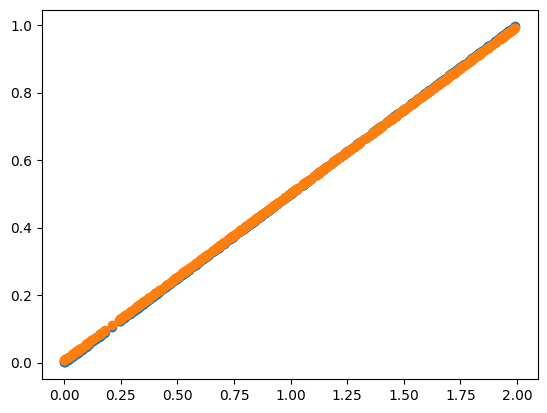

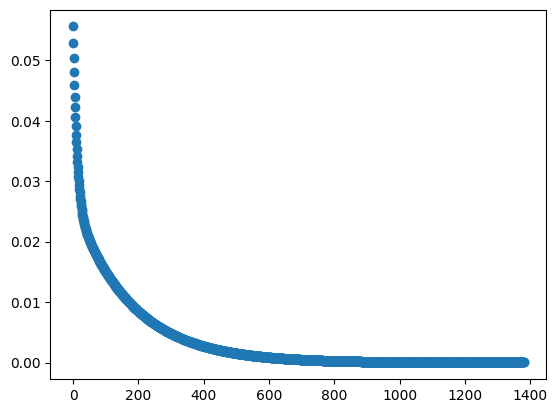

In [11]:
model.train()


## General Regression Model
- Inherit most methods from a base model.
- Applicable to univariate and multivariate linear regression.

In [12]:
class base_regression_model(abc.ABC):
    def __init__(
            self, data: pd.DataFrame, y_name: str, x_names, 
            iter_limit=1000, tolerance=1e-4, random_seed=33, plot_results=True,
            learning_rate=1e-3, use_momentum = True, momentum = 0.9):
        # Ensure x_names is a tuple or list
        if type(x_names) == str:
            x_names = (x_names, )
        
        # Data
        self.data = data
        
        # Formula: y = m·x + n * 1.0, where y, m, x and n are vectors 
        self.y = data.loc[:, y_name]
        self.x = data.loc[:, x_names]
        self.x['bias'] = 1.0 
        
        # Prediction and loss values initialization
        self.pred = np.repeat(0.0, repeats=len(self.y))
        self.loss = []

        # Learning Rate and momentum
        self.lr = learning_rate
        if use_momentum:
            self.momentum = momentum
        else:
            self.momentum = 0

        # Additional parameters to control how training is performed
        self.iter_limit = iter_limit
        self.tol = tolerance
        self.seed = random_seed
        self.plot_results = plot_results


    @abc.abstractmethod
    def _evaluate(self):
        """
        This method must be implemented by child classes.
        Should return a tuple: (loss, gradient_dict)
        """
        pass

    def _update(self, gradient: dict):
        for col in self.coeff:
            # Update velocity
            self.velocity[col] = self.momentum * self.velocity[col] + self.lr * gradient[col]

            # Update uses "-=" to advance in the direction of decreasing loss
            self.coeff[col] -= self.velocity[col]
    
    def predict(self, X: pd.DataFrame = None):
        '''
        Calculate the dot product of X with the coefficients. If X is not specified, then training data is used.
        '''
        if X is None:
            X = self.x

        return np.dot(
            X,
            np.array([self.coeff[col] for col in X.columns])
        )

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # Predicted vs actual
        axs[0].scatter(self.pred, self.y, alpha=0.6)
        axs[0].plot(
            [self.y.min(), self.y.max()],
            [self.y.min(), self.y.max()],
            color='red', linestyle='--',
            label = 'Ideal Fit'
        )

        axs[0].set_title('Predicted vs Actual')
        axs[0].set_xlabel('Predicted values')
        axs[0].set_ylabel('Actual Values')
        axs[0].legend()

        # Plot loss curve
        axs[1].scatter(np.arange(stop=len(self.loss)), self.loss, alpha=0.6, s=10)
        axs[1].set_title('Loss Over Iterations')
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('Loss')

        # Plot
        plt.tight_layout()
        plt.show()

    def train(self):
        '''
        Perform gradient descent iteratively to optimize coefficients.
        '''
        # Set random coefficients
        random.seed(self.seed)
        self.coeff = {
            x: random.uniform(-1.0, 1.0) for x in self.x
        }

        # Calculate prediction from random coefficients (starting point)
        self.pred = self.predict()

        # Initialize velocity (updates if momentum is usable)
        self.velocity = {key: 0 for key in self.coeff.keys()}

        for _ in range(self.iter_limit):
            # The loss function and its gradient
            (loss, gradient) = self._evaluate()
            self.loss.append(loss)

            # Check if the loss function is under the tolerated error (stop if true)
            if loss < self.tol:
                break
            
            # Update the coefficients
            self._update(gradient)
        
            # Calculate prediction with updated coefficients
            self.pred = self.predict()
        
        # Plot results
        if self.plot_results:
            self.plot()

    def summary(self):
        '''
        Statistical summary of the model.
        '''
        # Compute statistical measures
        mean_pred = np.mean(self.pred)
        num = np.sum([ (y - pred) ** 2 for (y,pred) in zip(self.y, self.pred)])
        den = np.sum([ (y - mean_pred) ** 2 for y in self.y ])
        r2 = 1 - num/den

        # Show results
        print('Model Summary')
        print('-' * 50)
        print(f'R^2 = {r2}')
        print(f'MSE = {self.loss[-1]}')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in self.x],
             'Coefficient': [value for value in self.coeff.values()]}
        ))

    
        



## Linear Regression

In [13]:
class linear_regression(base_regression_model):    
    def _evaluate(self):
        # Loss function:
        #   loss = 1/N sum_(i=1)^(N) (y_i - pred_i)^2,
        # where
        #   pred_i = coeff_i * x_i.
        errors = self.y - self.pred
        loss = np.mean(errors ** 2)
        
        # Gradient:
        # - For independent variables:  d(loss)/d(m_k) = -2/N sum_(i=1)^(N) [errors_i * self.x_i].
        # - For bias:                   d(loss)/d(m_k) = -2/N sum_(i=1)^(N) [errors_i * 1].
        # 
        # As self.x['bias'] = 1, extending the first expression to all variables, includes the bias.
        gradient = {
            var: (-2 * np.mean(errors * self.x[var])) for var in self.x
        }
        
        # Return loss function and gradients
        return (loss, gradient)

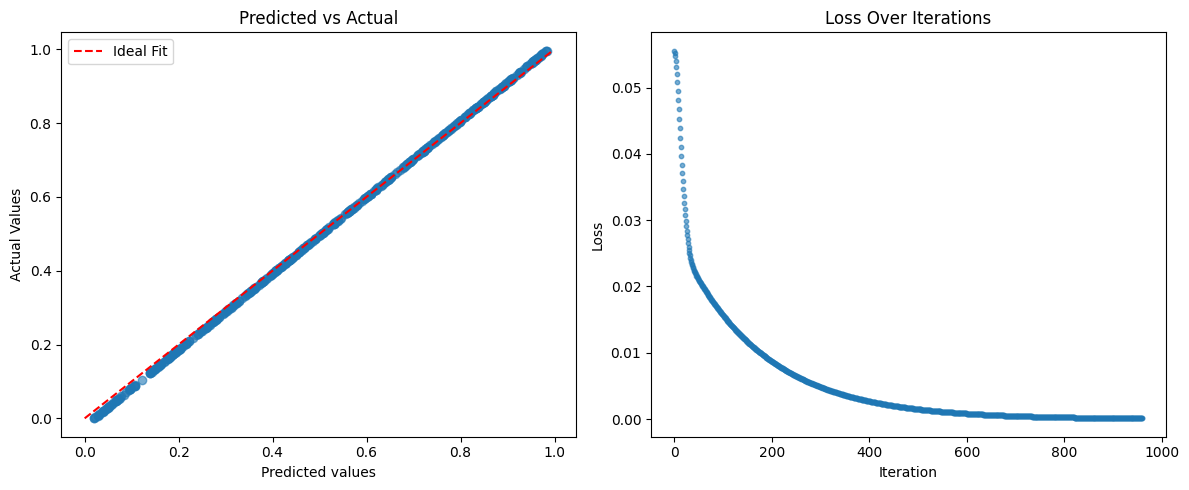

Model Summary
--------------------------------------------------
R^2 = 0.9987820904569787
MSE = 9.998106557331151e-05


,Variable,Coefficient
0,x1,0.483317
1,bias,0.020542


In [14]:
univariate_model = linear_regression(data, y_name='target', x_names='x1')
univariate_model.train()
univariate_model.summary()

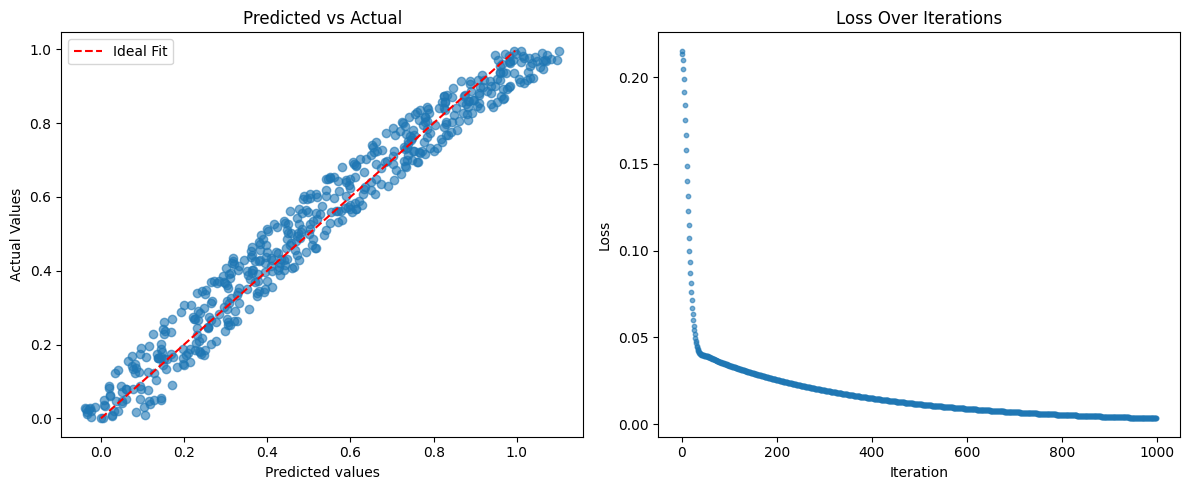

Model Summary
--------------------------------------------------
R^2 = 0.9602911609290247
MSE = 0.0032691862062059


,Variable,Coefficient
0,x1,0.371455
1,x2,0.284882
2,x3,0.175780
3,bias,-0.063149


In [15]:
multivariate_model = linear_regression(data, y_name='target', x_names=('x1', 'x2', 'x3'))
multivariate_model.train()
multivariate_model.summary()

## Logistic Regression

In [16]:
# Example Data
np.random.seed(33)
target = np.random.randint(low=0, high=2, size=500)
data = pd.DataFrame.from_dict({'target': target, 'x1': target * 2, 'x2': np.random.rand(500)})
data.head()

,target,x1,x2
0,0,0,0.020345
1,1,2,0.713095
2,0,0,0.969497
3,0,0,0.145036
4,0,0,0.007210


In [17]:
class logistic_regression(base_regression_model):
    def predict(self, X: pd.DataFrame = None):
        '''
        Override predict method to adapt to Logistic Regression.
        '''
        if X is None:
            X = self.x

        # Logistic Regression:
        #   p_n = 1 / (1 + exp(-z_n)),
        # where
        #   z_n = sum_{m=1}^M xnm bm
        z = np.dot(
            X,
            np.array([self.coeff[col] for col in X.columns])
        )

        return 1 / (1 + np.exp(-z))
    
    def _evaluate(self):
        eps = 1e-15 # avoid log(0)

        # Loss function:
        #   loss = -1/N sum_{n=1}^{N} [y_n log(p_n) + (1-y_n) log(1-p_n)],
        # where
        #   p_n = 1 / (1 + e^{-z_n}),
        # and
        #   z_n = sum_{m=1}^{M} x_{nm} b_m.
        errors = self.pred - self.y
        loss = -np.mean(self.y * np.log(self.pred + eps) + (1 - self.y) * np.log(1 - self.pred + eps))
        
        # Gradient:
        #   d(loss)/d(b_k) = 1/N sum_(i=1)^(N) [errors_i * self.x_i].
        gradient = {
            var: (np.mean(errors * self.x[var])) for var in self.x
        }
        
        # Return loss function and gradients
        return (loss, gradient)
    
    def predicted_class(self, X: pd.DataFrame = None, threshold = 0.5):
        return (self.predict(X) >= threshold).astype(int)
    
    def summary(self):
        '''
        Replace summary to adapt to Logistic Regression.
        '''
        # True Positives, True Negatives, False Positives and False Negatives
        TP = FP = TN = FN = 0
        for (y,p) in zip(self.y, self.predicted_class()):
            # Positives (prediction = 1)
            if p == 1:
                if p == y:
                    TP += 1
                else:
                    FP += 1
            else: # Negatives (prediction = 0)
                if p == y:
                    TN += 1
                else:
                    FN += 1

        # Compute statistical measures
        accuracy = (TP + TN) / len(self.y)
        precision = TP / (TP + FP)
        recall = TP / (TP +FN)

        # Show results
        print('Model Summary')
        print('-' * 50)
        print('Confusion Matrix')
        display(pd.DataFrame.from_dict(
            {'0': [TN, FN],
             '1': [FP, TP]}
        ))
        print(f'Accuracy = {accuracy}')
        print(f'Precision = {precision}')
        print(f'Recall = {recall}')
        print(f'Log-Loss = {self.loss[-1]}')
        display(pd.DataFrame.from_dict(
            {'Variable': [name for name in self.x],
             'Coefficient': [value for value in self.coeff.values()]}
        ))

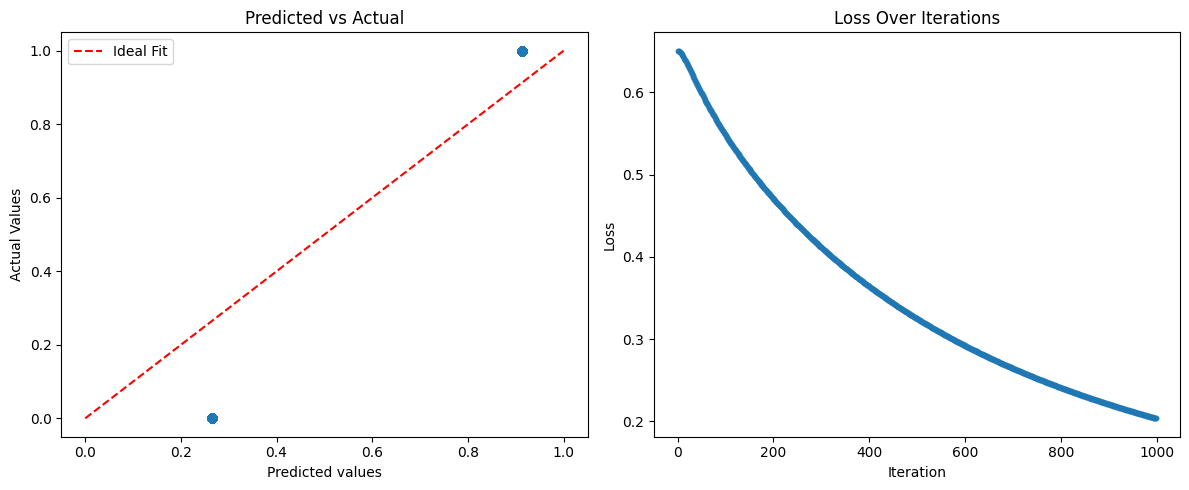

Model Summary
--------------------------------------------------
Confusion Matrix


,0,1
0,257,0
1,0,243


Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Log-Loss = 0.20345015918530027


,Variable,Coefficient
0,x1,1.680326
1,bias,-1.016285


In [18]:
univariate_model = logistic_regression(data, y_name='target', x_names='x1')
univariate_model.train()
univariate_model.summary()

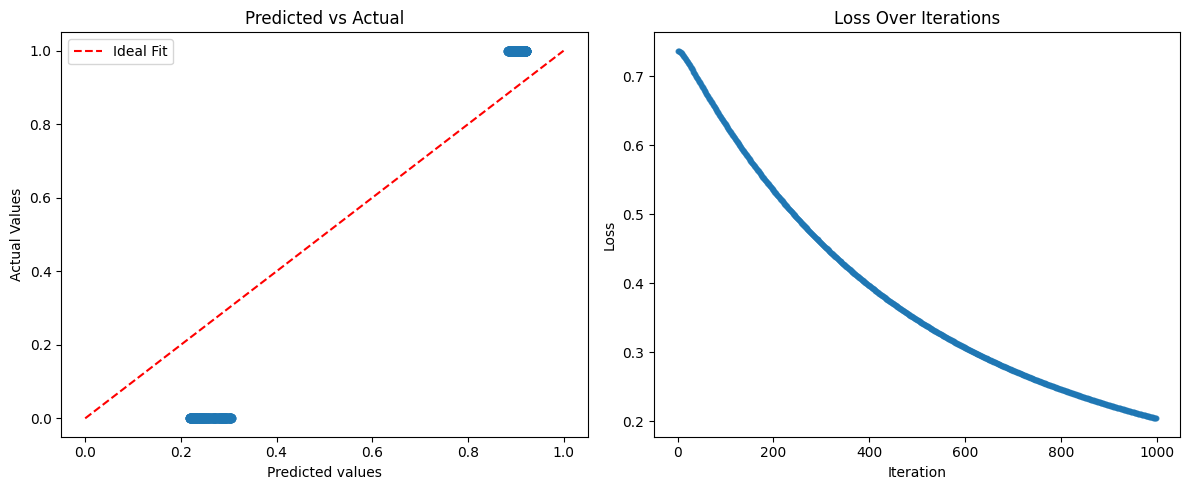

Model Summary
--------------------------------------------------
Confusion Matrix


,0,1
0,257,0
1,0,243


Accuracy = 1.0
Precision = 1.0
Recall = 1.0
Log-Loss = 0.2043588595360957


,Variable,Coefficient
0,x1,1.650512
1,x2,-0.451708
2,bias,-0.820924


In [19]:
multivariate_model = logistic_regression(data, y_name='target', x_names=('x1', 'x2'))
multivariate_model.train()
multivariate_model.summary()

## Polynomial Linear Regression

In [20]:
# Example data
N = 1000
y = np.random.random(size=N)
data = pd.DataFrame.from_dict(
    {
        'y': y,
        'x1': np.random.randint(low=0, high=5, size=N),
        'x2': np.sqrt(y)
    }
)

formula = 'y~ x1+ x2^2 +  x2'

display(data.head())

,y,x1,x2
0,0.507001,3,0.712040
1,0.716805,2,0.846644
2,0.173624,2,0.416682
3,0.853221,0,0.923700
4,0.474977,1,0.689186


The only change required for a polynomial linear regression, is to add some way of dealing with variables like $x_1^2$. This is solved by writing a formula and implementing a function that returns the desired data to evaluate (done in auxiliary_functions.py):

In [21]:
from auxiliary_functions import pandas_df_from_formula
df = pandas_df_from_formula(formula, data)
display(df.head())

,y,x1,x2,x2^2
0,0.507001,3,0.712040,0.507001
1,0.716805,2,0.846644,0.716805
2,0.173624,2,0.416682,0.173624
3,0.853221,0,0.923700,0.853221
4,0.474977,1,0.689186,0.474977


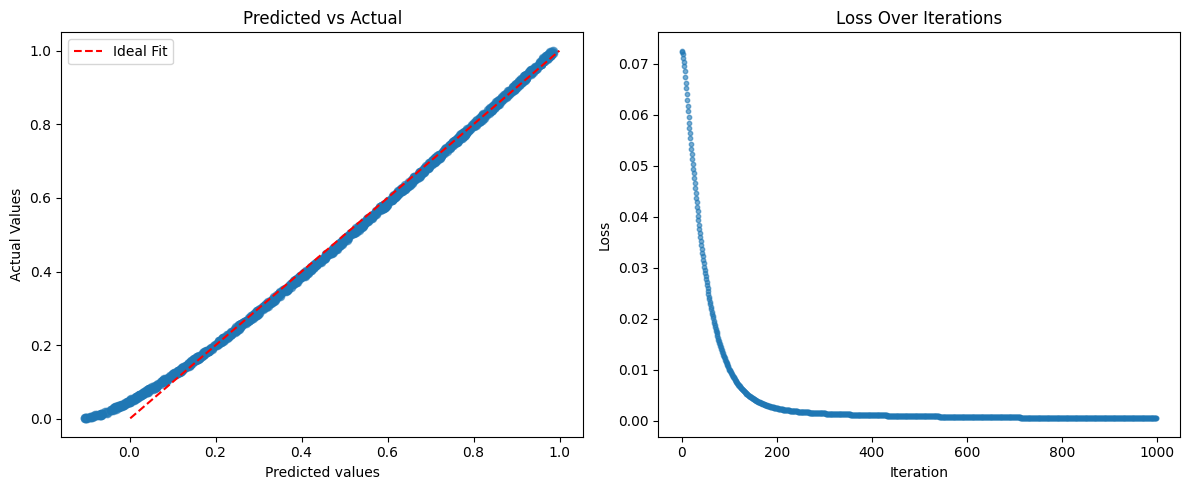

Model Summary
--------------------------------------------------
R^2 = 0.994968003518785
MSE = 0.00043312829230034703


,Variable,Coefficient
0,x1,0.002223
1,x2,0.394171
2,x2^2,0.712509
3,bias,-0.124890


In [23]:
multivariate_model = linear_regression(df, y_name='y', x_names=('x1', 'x2', 'x2^2'))
multivariate_model.train()
multivariate_model.summary()